

<h1> <center> <strong> Logistic Regression AND Ridge Regression </strong> </center> </h1>
<h1> <center> <strong> Haris Tahir Rana </strong> </center> </h1>

The required packages for this assignment are already present in the first cell.

If you are running the noteook on your PC/laptop, it is strongly advised that you install [conda](https://conda.io/projects/conda/en/latest/user-guide/getting-started.html) and work in a conda environment for this and future assignments. This will go a long way in ensuring you do not get dependency conflicts and your system does not slow down.

### Conda Instructions

After installing [conda](https://conda.io/projects/conda/en/latest/user-guide/getting-started.html), open a terminal/command prompt window in the assignment folder and run `conda env create -f environment.yml` command to automatically create an isolated conda environment titled `AI_env` with required packages installed. Then open/restart VSCode to select this environment as the kernel for your notebook. Your first cell should now compile smoothly. 

You can also check the output of the command `conda list -n AI_env` to see if each required package listed in the `environment.yml` file is present in this environment.

In [80]:
# Required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error, mean_squared_error # set 'squared' argument to false to get RMSE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn import model_selection

<h1> <center> Task 1A: Multinomial Logistic Regression </center> </h1>

### Problem Introduction

Logistic regression is primarily employed for classification problems. 

**Binary (or simple) logistic regression** deals with scenarios where the dependent variable has two possible outcomes e.g. yes/no, true/false etc. It models the probability of an observation belonging to one of the two categories.

**Multinomial logistic regression** extends binary logistic regression to handle situations with more than two categories (yes/no/maybe) for the dependent variable. It's useful for classification problems involving multiple classes. In this part, you will be implementing a model that can handle classification in one such multiclass case.

### Dataset
The dataset for this task is provided in a csv titled `star_classification.csv`. It consists of 100,000 observations of space taken by the SDSS (Sloan Digital Sky Survey). Every observation is described by 17 feature columns and 1 class column which identifies it to be either a star, galaxy or quasar. Following is the description of each column in the dataset.

<table>
<theader>
<tr>
<th>  # </th>
<th> Variable </th>
<th> Description </th>
</tr>
</theader>

<tbody>
<tr>
<td>  1  </td>
<td> obj_ID </td>
<td> Object Identifier, the unique value that identifies the object in the image catalog used by the CAS </td>
</tr>

<tr>
<td>  2  </td>
<td> alpha  </td>
<td> Right Ascension angle (at J2000 epoch) </td>
</tr>

<tr>
<td>  3 </td>
<td> delta </td>
<td> Declination angle (at J2000 epoch)  </td>
</tr>

<tr>
<td>  4  </td>
<td> u </td>
<td> Ultraviolet filter in the photometric system</td>
</tr>

<tr>
<td>  5  </td>
<td> g </td>
<td> Green filter in the photometric system  </td>
</tr>

<tr>
<td>  6  </td>
<td> r </td>
<td> Red filter in the photometric system   </td>
</tr>

<tr>
<td>  7  </td>
<td> i </td>
<td> Near Infrared filter in the photometric system   </td>
</tr>

<tr>
<td>  8  </td>
<td> z </td>
<td> Infrared filter in the photometric system  </td>
</tr>

<tr>
<td>  9  </td>
<td> run_ID </td>
<td> Run Number used to identify the specific scan  </td>
</tr>

<tr>
<td>  10  </td>
<td> rereun_ID  </td>
<td> Rerun Number to specify how the image was processed   </td>
</tr>

<tr>
<td>  11  </td>
<td> cam_col </td>
<td> Camera column to identify the scanline within the run  </td>
</tr>

<tr>
<td>  12  </td>
<td> field_ID  </td>
<td> Field number to identify each field   </td>
</tr>

<tr>
<td>  13  </td>
<td> spec_obj_ID </td>
<td> Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)    </td>
</tr>

<tr>
<td>  14  </td>
<td> class </td>
<td> Object class (galaxy, star, or quasar object) $\color{green}{\text{-> This column has the labels that your classifier will predict}}$   </td>
</tr>

<tr>
<td>  15  </td>
<td> redshift  </td>
<td> Redshift value based on the increase in wavelength  </td>
</tr>

<tr>
<td>  16  </td>
<td> plate  </td>
<td> Plate ID, identifies each plate in SDSS   </td>
</tr>

<tr>
<td>  17  </td>
<td> MJD </td>
<td> Modified Julian Date, used to indicate when a given piece of SDSS data was taken     </td>
</tr>

<tr>
<td>  18  </td>
<td> fiber_ID  </td>
<td> Fiber ID that identifies the fiber that pointed the light at the focal plane in each observation   </td>
</tr>

</tbody>
</table>


### Task

Our objective will be to build a classifier that can classify the `class` as either `star`, `galaxy` or `quasar` for instances in the test set.

### Note

It is $\color{red}{\text{NOT}}$ allowed to use `scikit-learn` for any part of this task. 

1. To start off, we load the .csv file as a pandas `DataFrame`, visualize it and report its shape.

In [68]:
df = pd.read_csv('star_classification.csv')

print ("Shape of the data frame: ", df.shape)

Shape of the data frame:  (100000, 18)


2. Then, we split the dataset into train and test sets.  

In [69]:
jumbled_df = df.sample(frac=1, random_state=42).reset_index(drop=True)

total_Rows = len(jumbled_df)
print ("rows: ", total_Rows)
training_size = int(0.7 * total_Rows)

training_set = jumbled_df.iloc[:training_size]
testing_set = jumbled_df.iloc[training_size:]

training_set.reset_index(drop=True, inplace=True)
testing_set.reset_index(drop=True, inplace=True)

print ("Shape of the training set: ", training_set.shape)
print ("Shape of the testing set: ", testing_set.shape)

rows:  100000
Shape of the training set:  (70000, 18)
Shape of the testing set:  (30000, 18)


Now that we have loaded the data and understood its structure, we will have to do some preprocessing to get features and class labels/categories for use with our classifier:

1. We make new DataFrames labelled `X_train` and `X_test` that have the feature columns only. We remove any features that we consider irrelevant for training the classifier. We could use trial and error to observe which set of attributes give us the best accuracy. (HINT: Check the dataset description given earlier to decide which columns might be dropped). 

2. We normalize both the train and test feature matrices. 

3. Report the shape and state what the dimensions of the normalized `X_train` and `X_test` represents.

4. Incorporate a bias vector of appropriate shape to the normalized feature matrices.

5. Report the first instance of the normalized train and test feature matrices before and after adding the bias vector.

In [70]:
# 1) EXTRACTING RELEVANT FEATURES

#                     2        3      4    5    6    7    8        15        16     17        18      
feature_columns = ['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'redshift', 'plate', 'MJD', 'fiber_ID']

X_train = training_set[feature_columns]
X_test = testing_set[feature_columns]

# 2) NORMALIZING TRAINING AND TESTING DATA

def normalize_data(data, mean, stdev):
    normalized_data = (data-mean)/stdev
    return normalized_data

X_train_mean = X_train.mean()
X_train_stdev = X_train.std()

X_train_normalized = normalize_data(X_train, X_train_mean, X_train_stdev)
#print (X_train_normalized)
X_test_normalized = normalize_data(X_test, X_train_mean, X_train_stdev)
#print (X_test_normalized)

# 3) SHAPE OF X_TRAIN AND X_TEST AND WHAT EACH REPRESENTS

print ("Shape of X_train: ", X_train.shape)
print ("Shape of X_test: ", X_test.shape)
print ("Shape of X_train_normalized: ", X_train_normalized.shape)
print ("Shape of X_test_normalized: ", X_test_normalized.shape)

print ("\n \nDimensions of X_train: \n")
print ("The x-coordinate represents the number of rows, i.e the number of samples in the training set. ")
print ("The y-coordinate represents the number of columns, i.e the number of input features in the training set. \n")
print ("Dimensions of X_test: \n")
print ("The x-coordinate represents the number of rows, i.e the number of samples in the testing set. ")
print ("The y-coordinate represents the number of columns, i.e the number of input features in the testing set. \n")

# 4) INCORPORATION OF BIAS VECTOR INTO NORMALIZED FEATURE MATRIX

X_train_normalized['bias'] = 1
X_test_normalized['bias'] = 1

X_train_normalized_after_bias = X_train_normalized[['bias'] + list(X_train_normalized.columns[:-1])]
X_test_normalized_after_bias = X_test_normalized[['bias'] + list(X_test_normalized.columns[:-1])]

#print (X_train_normalized_after_bias)
#print (X_test_normalized_after_bias)

print("Shape of X_train_normalized with bias:", X_train_normalized_after_bias.shape)
print("Shape of X_test_normalized with bias:", X_test_normalized_after_bias.shape)

# 5) REPORTING FIRST INSTANCE OF NORMALIZED TRAIN AND TEST FEATURE MATRICES BEFORE AND AFTER ADDING THE BIAS VECTOR.

print("\n \nFirst instance of X_train_normalized before adding bias: ")
print(X_train_normalized.iloc[0])

print("\nFirst instance of X_test_normalized before adding bias: ")
print(X_test_normalized.iloc[0])

print("\nFirst instance of X_train_normalized after adding bias:")
print(X_train_normalized_after_bias.iloc[0])

print("\nFirst instance of X_test_normalized after adding bias:")
print(X_test_normalized_after_bias.iloc[0])



Shape of X_train:  (70000, 11)
Shape of X_test:  (30000, 11)
Shape of X_train_normalized:  (70000, 11)
Shape of X_test_normalized:  (30000, 11)

 
Dimensions of X_train: 

The x-coordinate represents the number of rows, i.e the number of samples in the training set. 
The y-coordinate represents the number of columns, i.e the number of input features in the training set. 

Dimensions of X_test: 

The x-coordinate represents the number of rows, i.e the number of samples in the testing set. 
The y-coordinate represents the number of columns, i.e the number of input features in the testing set. 

Shape of X_train_normalized with bias: (70000, 12)
Shape of X_test_normalized with bias: (30000, 12)

 
First instance of X_train_normalized before adding bias: 
alpha      -1.668361
delta      -1.042748
u           0.036967
g           0.038635
r           0.452933
i           0.296876
z           0.013398
redshift   -0.096724
plate      -0.278861
MJD        -0.042471
fiber_ID    0.167935
bias   

6. Extract the class labels from the both train and test datasets, and convert them to NumPy arrays for faster preprocessing. Label these `y_train` and `y_test`. 

7. Report the shape of the `y_train` and `y_test` matrices.

In [71]:
y_train = training_set['class'].to_numpy()
y_test = testing_set['class'].to_numpy()

print (y_train)
print (y_test)

print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

['GALAXY' 'STAR' 'STAR' ... 'GALAXY' 'QSO' 'QSO']
['GALAXY' 'GALAXY' 'QSO' ... 'STAR' 'GALAXY' 'GALAXY']
Shape of y_train: (70000,)
Shape of y_test: (30000,)


As we have seen, `y_train` and `y_test` have class labels/categories in string format right now. However, many machine learning algorithms, such as logistic regression, support only numerical input features. They are designed to perform mathematical operations on numerical data, such as addition, subtraction, and multiplication. Therefore, we will first encode these string labels as integers, and then one-hot encode them.

7. Create a mapping that converts the current class labels to integers e.g. Class1: 0, Class2: 1 etc

8. Use the mapping to create updated `y_train` and `y_test`. 

In [72]:
mapping = {'GALAXY': 0, 'STAR': 1, 'QSO': 2}

y_train_encoded = np.array([mapping[label] for label in y_train])
y_test_encoded = np.array([mapping[label] for label in y_test])

print("Encoded class labels for y_train:")
print(y_train_encoded)
print("\nEncoded class labels for y_test:")
print(y_test_encoded)


Encoded class labels for y_train:
[0 1 1 ... 0 2 2]

Encoded class labels for y_test:
[0 0 2 ... 1 0 0]


Currently, our updated `y_train` and `y_test` are represented by integers. However, using this ordinal encoding (assigning integers to categories) may introduce an inherent order or magnitude between categories that does not exist in the original data. 

One-hot encoding avoids this issue by representing each category as a separate binary variable, thereby treating them as equally important and removing any ordinal bias. In logistic regression, when dealing with multiple classes, one-hot encoding enables the model to predict probabilities for each class independently. Each class is represented by its own binary variable, and the model learns separate coefficients for each class, allowing it to make predictions across multiple classes.

Example:  If `y_train = [0,0,1,2]` then one-hot encoded representation of this vector would be: `[[1,0,0], [1,0,0], [0,1,0], [0,0,1]]`

9. Write a function to one-hot encode the labels.

10. Call the function to get one-hot encoded labels for both train and test sets.

In [73]:
def one_hot_encode(array, num_classes):

    n_samples = len(array)
    one_hot_encoded = np.zeros((n_samples, num_classes))
    
    for i in range(n_samples):
        class_index = array[i]
        one_hot_encoded[i, class_index] = 1
    
    return one_hot_encoded

n = 3  # number of classes: star, galaxy, QSO
y_train_one_hot_encoded = one_hot_encode(y_train_encoded, n)
y_test_one_hot_encoded = one_hot_encode(y_test_encoded, n)


print(y_train_encoded)
print("One-hot encoded labels for y_train: ")
print(y_train_one_hot_encoded)
print("One-hot encoded labels for y_test: ")
print(y_test_one_hot_encoded)


[0 1 1 ... 0 2 2]
One-hot encoded labels for y_train: 
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]
One-hot encoded labels for y_test: 
[[1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 ...
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


Report the first 10 instances of:

1. The original `y_train` and `y_test` arrays.
2. The integer-encoded `y_train` and `y_test` arrays. 
3. The one-hot encoded `y_train` and `y_test` arrays. 

In [74]:
# Original y_train and y_test arrays:
print("First 10 instances of original y_train:")
print(y_train[:10])
print("\nFirst 10 instances of original y_test:")
print(y_test[:10])

# Integer-encoded y_train and y_test arrays:
print("\nFirst 10 instances of integer-encoded y_train:")
print(y_train_encoded[:10])
print("\nFirst 10 instances of integer-encoded y_test:")
print(y_test_encoded[:10])

# One-hot encoded y_train and y_test arrays:
print("\nFirst 10 instances of one-hot encoded y_train:")
print(y_train_one_hot_encoded[:10])
print("\nFirst 10 instances of one-hot encoded y_test:")
print(y_test_one_hot_encoded[:10])


First 10 instances of original y_train:
['GALAXY' 'STAR' 'STAR' 'STAR' 'STAR' 'QSO' 'GALAXY' 'QSO' 'GALAXY'
 'GALAXY']

First 10 instances of original y_test:
['GALAXY' 'GALAXY' 'QSO' 'GALAXY' 'GALAXY' 'GALAXY' 'QSO' 'GALAXY'
 'GALAXY' 'GALAXY']

First 10 instances of integer-encoded y_train:
[0 1 1 1 1 2 0 2 0 0]

First 10 instances of integer-encoded y_test:
[0 0 2 0 0 0 2 0 0 0]

First 10 instances of one-hot encoded y_train:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]]

First 10 instances of one-hot encoded y_test:
[[1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


We are now ready to use the above matrices/arrays to implement our classifier and evaluate it on the test set. 

### We need to implement the following:

 * Softmax function
 * Cross-entropy loss function
 * Batch Gradient Descent function
 * Prediction function that predicts output class using learned logistic regression (choose the highest probability class)
 * Evaluation function that calculates classification accuracy on test set 
 * Report plots with no. of iterations/epochs on x-axis and training/validation loss on y-axis.

In [75]:
 # 1) SOFTMAX FUNCTION

def softmax(z):
    softmax_array = np.exp(z)
    sum = np.sum(softmax_array, axis=1, keepdims=True)
    probs = softmax_array/sum
    return probs

def cross_entropy_loss(y_actual, y_predicted):
    loss = -np.mean(np.sum((y_actual * np.log(1e-9 + y_predicted))))
    return loss

def batch_gradient_descent(X, y, alpha, epochs, n_classes):
    m, n_features = X.shape
    thetas = np.zeros((n_features, n_classes))
    J = []
    
    for epoch in range (epochs):
        y_initial = np.dot(X, thetas)
        y_predicted = softmax(y_initial)
        loss = cross_entropy_loss(y, y_predicted)
        J.append(loss)
        gradient = np.dot(X.T, (y_predicted - y)) / m
        thetas = thetas - (alpha * gradient)
    
        print(f"Iteration {epoch}: Loss {loss}")
    return thetas, J

def predict_output_class (X, thetas):
    y_initial = np.dot(X, thetas)
    probs = softmax(y_initial)
    predictions = np.argmax(probs, axis=1)
    return predictions

def classification_accuracy(y_actual, y_predicted):
    count = 0
    for i in range (len(y_actual)):
        if (y_actual[i] == y_predicted[i]):
            count = count + 1
    accuracy = (count/len(y_actual))*100
    print ("Accuracy: ", accuracy, " %")
    return accuracy         

In [88]:
n_epoch = 25000
learning_rate = 0.01
n_classes = 3
thetas, J= batch_gradient_descent(X_train_normalized_after_bias, y_train_one_hot_encoded, learning_rate, n_epoch, n_classes) 

y_train_pred = predict_output_class(X_train_normalized_after_bias.values, thetas)
y_test_pred = predict_output_class(X_test_normalized_after_bias.values, thetas)

train_accuracy = classification_accuracy(y_train_encoded, y_train_pred)
print ("Training accuracy: " , train_accuracy)
test_accuracy = classification_accuracy(y_test_encoded, y_test_pred)
print ("Testing accuracy: " , test_accuracy)

train_accuracy, test_accuracy, J[-1]

Iteration 0: Loss 76902.8599967677
Iteration 1: Loss 76675.47780754419
Iteration 2: Loss 76451.37770342844
Iteration 3: Loss 76230.48884499662
Iteration 4: Loss 76012.74203846317
Iteration 5: Loss 75798.06970360932
Iteration 6: Loss 75586.40584206053
Iteration 7: Loss 75377.68600590927
Iteration 8: Loss 75171.84726667075
Iteration 9: Loss 74968.82818455754
Iteration 10: Loss 74768.56877805738
Iteration 11: Loss 74571.01049380294
Iteration 12: Loss 74376.09617672452
Iteration 13: Loss 74183.77004048375
Iteration 14: Loss 73993.9776381904
Iteration 15: Loss 73806.66583340868
Iteration 16: Loss 73621.78277146522
Iteration 17: Loss 73439.27785107154
Iteration 18: Loss 73259.10169627758
Iteration 19: Loss 73081.2061287732
Iteration 20: Loss 72905.54414055451
Iteration 21: Loss 72732.06986697137
Iteration 22: Loss 72560.73856017206
Iteration 23: Loss 72391.50656295805
Iteration 24: Loss 72224.33128306185
Iteration 25: Loss 72059.17116785754
Iteration 26: Loss 71895.98567951239
Iteration 27: 

(91.5642857142857, 91.31666666666666, 20556.81659227737)

## Task 1B: Reflection Questions

#### 1. How did normalization help in our case? Why did we need it? 

Normalization helps in improving the covergence of algorithms faster during training. By scaling the features to a similar range, the training algorithm converges more quickly. Secondly, normalization ensures that all features contribute equally to the learning process of the model. Without normalization, some features with larger magnitudes (eg: alpha) may dominate the learning process as compared to features with smaller magnitudes (eg: redshift, u, g), potentially leading to bias in the predictions of the model.
#### 2. What function instead of Softmax would we have used if this was a binary classification problem? How does softmax differ from it? 

In binary classification, the sigmoid function is used instead of the softmax function. The first difference between the sigmoid function and the softmax function is that the sigmoid function is used only for binary classification whereas the softmax function can be used for multiclass classification. Secondly, the sigmoid function outputs a single probability that an input belongs to the positive class whereas the softmax function normalizes the input values into a probability distribution, where each class probability is between 0 and 1, the sum of all classes is 1, and the max value represents the likelihood of the input feature belonging to a certain class. 

<h1> <center> Task 2: Regularization - Ridge Regression </center> </h1>

### Problem Introduction

This task is intended to familiarise you with regularization in the context of linear regression.

While training regression models, it is useful to ensure that there are some constraints on the weights learnt. These constraints are usually defined by some kind of penalty function included in the overall loss function. Generally, penalizing the norm of our weights means that during the training process, our model will prefer smaller values of weights.

We shall look at two types of regularization techniques. <br> <br>
The first is Ridge Regression:
\begin{equation*}
\mathcal{L} = \frac{1}{N}(y - X\mathbf{w})^{2} + \lambda (\mathbf{w})^{2}
\end{equation*}

The second is Lasso Regression:
\begin{equation*}
\mathcal{L} = \frac{1}{N}(y - X\mathbf{w})^{2} + \lambda |\mathbf{w}|
\end{equation*}

The L2 penalty on the weights penalizes larger values more than smaller ones while the L1 penalty penalizes all kinds of weights equally. The L1 penalty is also used to promote sparsity in the learnt weights (i.e. make certain weights which do not have a strong correlation with the data).

Please also note, for regularization to function properly, input **data must be normalized** to have zero mean and unit variance. We will be using StandardScaler() for this task.

### Dataset

The dataset for this part is provided in a .csv file titled `auto_mpg.csv`. 

### Task

Our task is to implement a linear regression model to predict car `displacement` using the feature `mpg`. We will test different values of the regularization parameter (`lambd`) to see which value gives us the lowest training and testing loss.

1. To begin, load the `auto_mpg_dataset.csv` dataset into a pandas DataFrame, visualize it and report its shape.

In [97]:
df = pd.read_csv('auto_mpg.csv')

print ("Shape of the dataset: ", df.shape)
print ("Visualization: ", df.head())

Shape of the dataset:  (398, 9)
Visualization:      mpg  cylinders  displacement horsepower  weight  acceleration  model year  \
0  18.0          8         307.0        130    3504          12.0          70   
1  15.0          8         350.0        165    3693          11.5          70   
2  18.0          8         318.0        150    3436          11.0          70   
3  16.0          8         304.0        150    3433          12.0          70   
4  17.0          8         302.0        140    3449          10.5          70   

   origin                   car name  
0       1  chevrolet chevelle malibu  
1       1          buick skylark 320  
2       1         plymouth satellite  
3       1              amc rebel sst  
4       1                ford torino  


2. Extract the columns `mpg` and `displacement` and normalize these features by using a builtin function `StandardScaler()`.

In [98]:
X = df[['mpg']].values
y = df[['displacement']].values

scaler_X = StandardScaler()
X_normalized = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_normalized = scaler_y.fit_transform(y)

print ("X_Normalized data: ")
print (X_normalized[:10])
print ("\n \ny_Normalized data: ")
print (y_normalized[:10])

X_Normalized data: 
[[-0.7064387 ]
 [-1.09075062]
 [-0.7064387 ]
 [-0.96264665]
 [-0.83454267]
 [-1.09075062]
 [-1.2188546 ]
 [-1.2188546 ]
 [-1.2188546 ]
 [-1.09075062]]

 
y_Normalized data: 
[[1.0906037 ]
 [1.5035143 ]
 [1.19623199]
 [1.06179598]
 [1.04259084]
 [2.26211751]
 [2.50218182]
 [2.36774581]
 [2.51178439]
 [1.88761719]]


3. Split the data into train and test sets. Make use of the `train_test_split` function from the scikit-learn library for this. The documentation for this function can be found [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split). 
- Use an 80-20 split, meaning 80% should be the training set and 20% should be for the test set.

In [99]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_normalized, y_normalized, test_size= 0.2, random_state= 42)

print ("Shape of training input data: ", X_train.shape)
print ("Shape of testing input data: ", X_test.shape)
print ("Shape of training output data: ", y_train.shape)
print ("Shape of testing output data: ", y_test.shape)

Shape of training input data:  (318, 1)
Shape of testing input data:  (80, 1)
Shape of training output data:  (318, 1)
Shape of testing output data:  (80, 1)


We shall now use gradient descent and analytical solution to fit the model parameters. To do so, we must complete the `LinearRegression` class provided. This class should work for Ridge Regression.

Furthermore, it should be able to compute solutions `analytically` as below:

\begin{equation*}
(X^T X)^{-1} \cdot (X^T Y)
\end{equation*} 

as well as via gradient descent. 

A function to generate the feature matrix for a specified polynomial degree has been provided.

In [105]:
class LinearRegression:
    """
    A class to perform linear regression

    Methods:
        __init__(self, lambd, degree)                                                  : Initializes the LinearRegression instance.
        _normalize_input(self, x)                                                      :
        _generate_X(self, x)                                                           : Generate the matrix X containing samples of data upto the degree specified.
                                                                                         Bias term is included (i.e. first column is all ones).
        analytical_solution(self, x, y)                                                : Find the analytical solution for model weights which minimizes mean square error
        gradient_descent_solution(self, x, y, learning_rate, num_iterations, tol=1e-4) : Find a gradient descent based solution for model weights which minimizes mean square error.
    """
    def __init__(self, lambd, degree):

        self.lambd = lambd
        self.degree = degree

    def _generate_X(self, x):
        """
        Generate the matrix X containing samples of data upto the degree specified.
        Bias term is included (i.e. first column is all ones).

        Args:
            x (numpy.ndarray) : Input data of shape (num_points, 1)

        Returns:
            X (numpy.ndarray) : Matrix of shape (num_points, degree+1)
        """
        polynomial_features = PolynomialFeatures(degree=self.degree)
        X = polynomial_features.fit_transform(x)
        return X

    def analytical_solution(self, x, y): 
        """
        Find the analytical solution for model weights which minimizes mean square error

        Args:
            x (numpy.ndarray) : x values of data
            y (numpy.ndarray) : y values of data

        Returns:
            w                 : list of optimal weights for regression
        """
        X = self._generate_X(x)
        I = np.eye(X.shape[1])
        I[0,0] = 0
        w = np.linalg.inv(X.T @ X + self.lambd * I) @ X.T @ y
        return w
        
        
    def gradient_descent_solution(self, x, y, learning_rate, num_iterations, tol=1e-4):
        """
        Find a gradient descent based solution for model weights which minimizes mean square error.

        Args:
            x (numpy.ndarray)    : x values of data
            y (numpy.ndarray)    : y values of data
            learning_rate (float): Learning rate for each gradient descent step
            num_iterations (int) : Number of iterations to perform before returning
            tol (float)          : value of epsilon s.t. when ||grad(f(x))||_{2} < epsilon, the algorithm terminates

        Returns:
        w               : list of optimal weights for regression
        """
        X = self._generate_X(x)
        m, n = X.shape
        w = np.zeros((n,1))
        for i in range (num_iterations):
            gradient = 2 * X.T @ (X @ w - y) / m + 2 * self.lambd * np.r_[[[0]], w[1:]]
            if np.linalg.norm(gradient) < tol:
                break
            w = w - (learning_rate * gradient)
        return w

5. 
- Use the LinearRegression class implemented above to compute weights using analytical and gradient descent solutions for each value of lambd. 
- Using these computed weights, predict the displacement (this will be Y_predicted). 
- Also plot the curves showing training and testing RMSE`(Y - Y_predicted)^2` for each value of `lambd`. We will be taking a polynomial of `degree 3 with 100 values of lambda ranging from 0 to 10`.

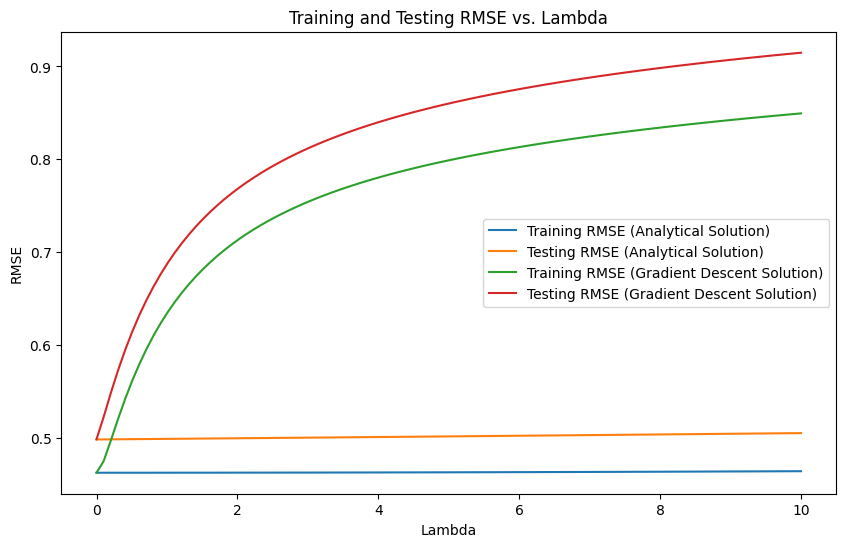

In [115]:
lambdas = np.linspace(0, 10, 100)

# Analytical Solution

training_rmse_analytical = []
testing_rmse_analytical = []

for lambd in lambdas:
    model = LinearRegression(lambd, 3)
    w_analytical = model.analytical_solution(X_train, y_train)
    
    X_train_poly = model._generate_X(X_train)
    y_train_predicted_analytcial = X_train_poly @ w_analytical
    X_test_poly = model._generate_X(X_test)
    y_test_predicted_analytcial = X_test_poly @ w_analytical
    
    train_rmse = np.sqrt(np.mean((y_train - y_train_predicted_analytcial) ** 2))
    test_rmse = np.sqrt(np.mean((y_test - y_test_predicted_analytcial) ** 2))
    
    training_rmse_analytical.append(train_rmse)
    testing_rmse_analytical.append(test_rmse)

# Gradient Descent Solution

training_rmse_gd = []
testing_rmse_gd = []

learning_rate = 0.01
num_iterations = 1000

for lambd in lambdas:
    model = LinearRegression(lambd, 3)
    
    w_gradient_descent = model.gradient_descent_solution(X_train, y_train, learning_rate, num_iterations)
    
    y_train_predicted_gd = X_train_poly @ w_gradient_descent
    y_test_predicted_gd = X_test_poly @ w_gradient_descent
    
    train_rmse_gd = np.sqrt(np.mean((y_train - y_train_predicted_gd) ** 2))
    test_rmse_gd = np.sqrt(np.mean((y_test - y_test_predicted_gd) ** 2))
    
    training_rmse_gd.append(train_rmse_gd)
    testing_rmse_gd.append(test_rmse_gd)
    
    
plt.figure(figsize=(10, 6))
plt.plot(lambdas, training_rmse_analytical, label='Training RMSE (Analytical Solution)')
plt.plot(lambdas, testing_rmse_analytical, label='Testing RMSE (Analytical Solution)')
plt.plot(lambdas, training_rmse_gd, label='Training RMSE (Gradient Descent Solution)')
plt.plot(lambdas, testing_rmse_gd, label='Testing RMSE (Gradient Descent Solution)')
plt.xlabel('Lambda')
plt.ylabel('RMSE')
plt.title('Training and Testing RMSE vs. Lambda')
plt.legend()
plt.show()

6. Plot the output of the model with the least validation RMSE overlaid on top of the original data (mpg vs displacement).

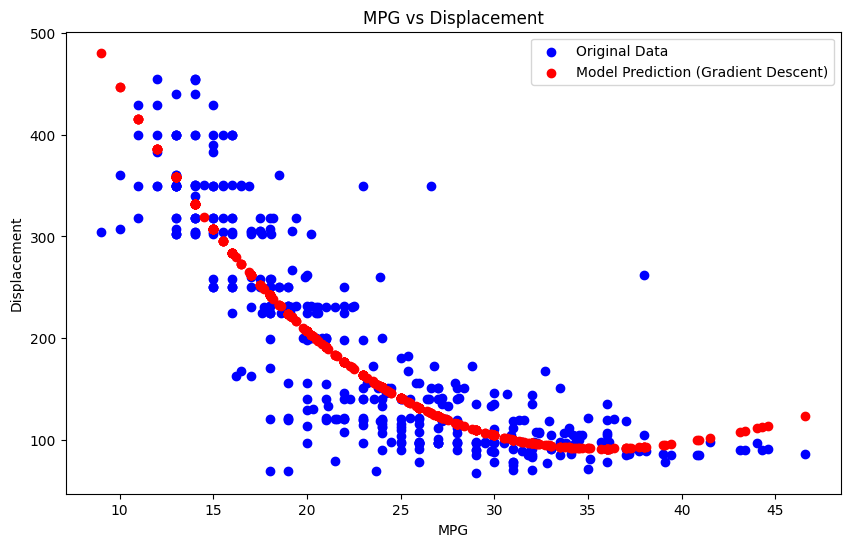

In [119]:

min_rmse_index_gd = np.argmin(testing_rmse_gd)
best_lambda_gd = lambdas[min_rmse_index_gd]

model_best_gd = LinearRegression(best_lambda_gd, 3)
w_best_gd = model_best_gd.gradient_descent_solution(X_normalized, y_normalized, learning_rate, num_iterations)

X_poly = model_best_gd._generate_X(X_normalized)
y_predicted_gd = X_poly @ w_best_gd

y_predicted_denorm_gd = scaler_y.inverse_transform(y_predicted_gd)
X_denorm = scaler_X.inverse_transform(X_normalized)

plt.figure(figsize=(10, 6))
plt.scatter(X_denorm, y, label='Original Data', color='blue')
plt.scatter(X_denorm, y_predicted_denorm_gd, label='Model Prediction (Gradient Descent)', color='red')
plt.xlabel('MPG')
plt.ylabel('Displacement')
plt.title('MPG vs Displacement')
plt.legend()
plt.show()

6. What do you notice about the effect of varying $\lambda$ on dataset (the effect on the training/testing loss)?       
$\color{green}{\text{Answer:}}$ For the gradient descent algorithm, as the value of lambda increases gradually, the rmse also increases for both the training and the testing data. 
Conversely, for the analytical solution, as the value of lambda increases, the rmse does not change by much for either the training or the testing data.


7. If we were to vary `learning rate` on dataset, what effect do you think it would have on the training/testing loss?                                                               
$\color{green}{\text{Answer:}}$ A very high learning rate can cause the gradient descent algorithm to overshoot the minimum of the loss function, potentially leading to a diverging solution. On the other hand, a very low learning rate can lead to extremely slow convergence towards the loss function's minimum value, requiring a very large number of iterations to converge, which can take alot of time.